# Классификация при помощи сверточных нейронных сетей (CNN)

In [1]:
!pip install imutils
!pip install opencv-contrib-python
!pip install tensorflow

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import os
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import numpy as np
import matplotlib.pyplot as plt
import random

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25870 sha256=1235e813cadaed1b85d3b43bb3c009c6a7350768063e8f8dab3357645c4d6918
  Stored in directory: /root/.cache/pip/wheels/31/d0/2c/87ce38f6052879e5b7b18f0f8b4a10ad2a9d210e908d449f16
Successfully built imutils
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 68.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 107.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 98.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 95.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("asdasdasasdas/garbage-classification")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/garbage-classification


In [3]:
DATA_DIR = "/kaggle/input/garbage-classification/Garbage classification/Garbage classification"
IMG_SIZE = (224,224)
BATCH_SIZE = 32

train_data_generator = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)

test_data_generator = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2)

train_generator = train_data_generator.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

val_generator = test_data_generator.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

num_classes = train_generator.num_classes
print(f"Классы: {train_generator.class_indices}")
print(f"Количество классов: {num_classes}")

Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.
Классы: {'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}
Количество классов: 6


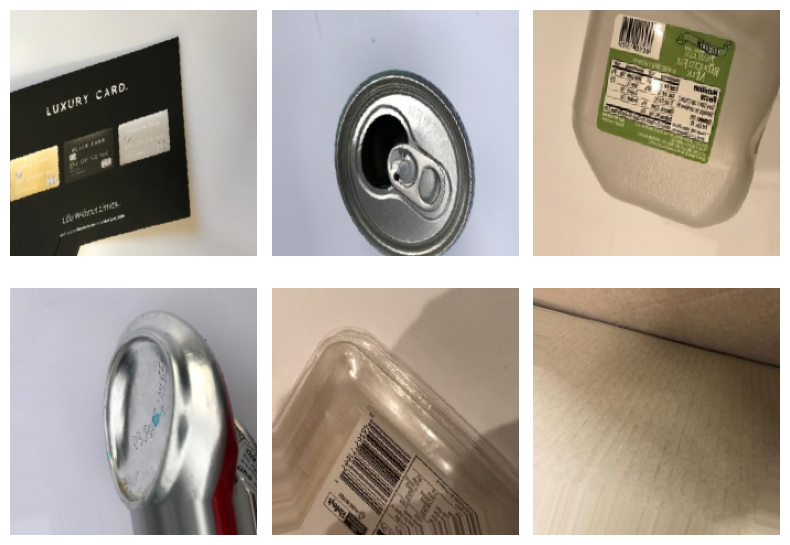

In [10]:
def show_img(img):
    plt.imshow(img)
    plt.axis('off')

images, labels = next(iter(train_generator))

plt.figure(figsize=(8, 6))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    show_img(images[i])
plt.tight_layout()
plt.show()


In [11]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=2, strides=(2,2)),

    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=2, strides=(2,2)),

    Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=2, strides=(2,2)),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     6,422,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,518,118 (24.86 MB)

 Trainable params: 6,518,118 (24.86 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
]

In [14]:
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 173s 3s/step - accuracy: 0.2282 - loss: 1.7770 - val_accuracy: 0.3797 - val_loss: 1.5734
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 165s 3s/step - accuracy: 0.3458 - loss: 1.5299 - val_accuracy: 0.3658 - val_loss: 1.5483
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 164s 3s/step - accuracy: 0.3999 - loss: 1.4354 - val_accuracy: 0.4135 - val_loss: 1.4520
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 165s 3s/step - accuracy: 0.4175 - loss: 1.3698 - val_accuracy: 0.4175 - val_loss: 1.4083
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 164s 3s/step - accuracy: 0.4492 - loss: 1.3769 - val_accuracy: 0.4751 - val_loss: 1.3431
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 164s 3s/step - accuracy: 0.4940 - loss: 1.2876 - val_accuracy: 0.4215 - val_loss: 1.4324
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 163s 3s/step - accuracy: 0.5030 - loss: 1.2672 - val_accuracy: 0.4294 - val_loss: 1.3794
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 163s 3s/step - accuracy: 0.5261 - loss: 1.2451 - val_accuracy: 0.4175 - v

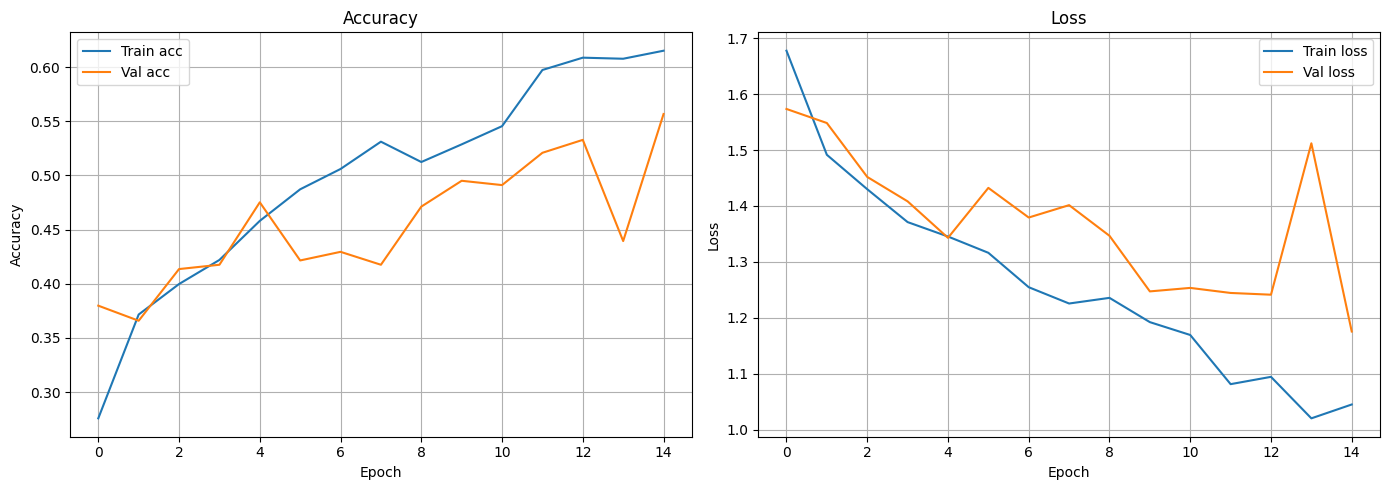

In [15]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train acc')
plt.plot(history.history['val_accuracy'], label='Val acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [16]:
loss, acc = model.evaluate(val_generator, batch_size=BATCH_SIZE)
print("\nTest accuracy: %.1f%%" % (100.0 * acc))
print("\nTest loss: %.1f%%" % (100.0 * loss))

16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 594ms/step - accuracy: 0.6109 - loss: 1.1122

Test accuracy: 55.7%

Test loss: 117.6%


In [17]:
val_generator

In [18]:
num_batches = min(1000, len(val_generator))
y_true = []
y_pred = []

for i in range(num_batches):
    x_batch, y_batch = val_generator[i]
    preds = model.predict(x_batch)

    y_true.extend(np.argmax(y_batch, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

target_names = list(val_generator.class_indices.keys())

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step


In [19]:
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   cardboard       0.72      0.59      0.65        80
       glass       0.48      0.61      0.54       100
       metal       0.55      0.48      0.51        82
       paper       0.54      0.86      0.66       118
     plastic       0.71      0.25      0.37        96
       trash       0.40      0.30      0.34        27

    accuracy                           0.56       503
   macro avg       0.57      0.51      0.51       503
weighted avg       0.58      0.56      0.54       503



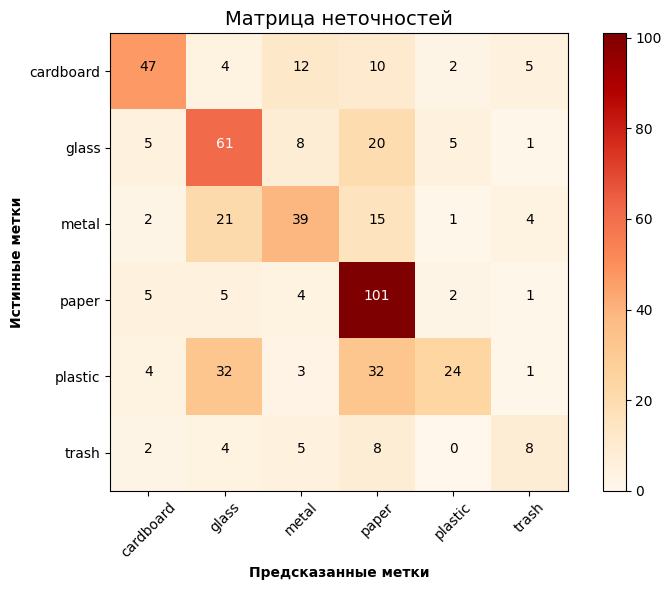

In [20]:
cm = confusion_matrix(y_true, y_pred)

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.OrRd):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Истинные метки', fontweight="bold")
    plt.xlabel('Предсказанные метки', fontweight="bold")
    plt.tight_layout()


plot_confusion_matrix(cm, classes=target_names, title='Матрица неточностей')